In [1]:
# import standard libraries
import numpy as np
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-76hfiwxk because the default path (/home/jaron/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Compare Auto Diff speed

In [31]:
# JAX
import jax 
import jax.numpy as jnp

# random parameters
dim = 20
A = np.random.randn(dim, dim)
A = -(A@A.T)
b = np.random.randn(dim)/10.
x = np.random.randn(dim)

# function 
f = lambda x, A, b: A@x + b

In [32]:
# gradient of function w.r.t x 
f_grad_x = jax.jit(jax.jacfwd(f, 0))
%timeit f_grad_x(x, A, b)

11 µs ± 198 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [34]:
# gradient of function w.r.t A 
f_grad_A = jax.jit(jax.jacfwd(f, 1))
%timeit f_grad_A(x, A, b)

114 µs ± 2.74 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [33]:
# gradient of function w.r.t b
f_grad_b = jax.jit(jax.jacfwd(f, 2))
%timeit f_grad_b(x, A, b)

7.15 µs ± 146 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [26]:
# PyTorch
import torch
import functorch

A = torch.tensor(A, dtype=torch.float32)
b = torch.tensor(b, dtype=torch.float32)
x = torch.tensor(x, dtype=torch.float32)

f = lambda x, A, b: A@x + b

In [27]:
# gradient of function w.r.t x 
f_grad_x = functorch.jacfwd(f, 0)
%timeit f_grad_x(x, A, b)

470 µs ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [28]:
# gradient of function w.r.t A 
f_grad_A = functorch.jacfwd(f, 1)
%timeit f_grad_A(x, A, b)

516 µs ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [29]:
# gradient of function w.r.t b
f_grad_b = functorch.jacfwd(f, 2)
%timeit f_grad_b(x, A, b)

382 µs ± 1.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Compare ODE solver speed

In [35]:
# method 1, JAX 
import jax 
import jax.numpy as jnp
from jax.experimental.ode import odeint

In [37]:
# dimension of problem 
dim = 15

# make a stable system (eigenvalues of A must be negative)
A = np.random.randn(dim, dim)
A = -(A@A.T)
b = np.random.randn(dim)/10.
params = (A, b)

# random initial conditions 
x0 = np.random.randn(dim)

# time horizon
t_eval = np.linspace(0, 5, 20)

# define linear differential equation
def system(x, t, params):
    A = params[0]
    b = params[1]
    return A@x + b

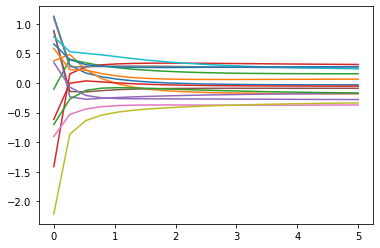

In [38]:
# solve ode 
y = odeint(system, x0, t_eval, params)
plt.plot(t_eval, y)
plt.show()

In [41]:
# define augmented system with forward sensitivity equations where
# dZ/dt = Jx@Z + Jp
Jx = jax.jit(jax.jacfwd(system, 0))
Jp = jax.jit(jax.jacfwd(system, 2))

def fwd_system(aug_x, t, params):
    # unpack dependent variables
    x = aug_x[0]
    # Y = aug_x[1]
    Z = aug_x[1:]
    
    # time derivative of state 
    dxdt = system(x, t, params)
    
    # system jacobian
    Jx_i = Jx(x, t, params)
    
    # time derivative of grad(state, initial condition)
    # dYdt = Jx_i@Y
    
    # time derivative of parameter sensitivity
    dZdt = [Jx_i@Z_i + Jp_i for Z_i, Jp_i in zip(Z, Jp(x, t, params))]
    
    return (dxdt, *dZdt)

In [42]:
# # solve ode 
Y0 = np.eye(dim)
Z0 = [np.zeros([dim] + list(param.shape)) for param in params]

xYZ0 = (x0, *Z0)
jax_soln = odeint(fwd_system, xYZ0, t_eval, params)
%timeit odeint(fwd_system, xYZ0, t_eval, params)

33.9 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
# Method 3: pytorch functools 

import functorch
import torch
import torch.nn as nn
from torchdiffeq import odeint

# set cpu or cuda 
device = 'cuda'

# make a stable system (eigenvalues of A must be negative)
A = torch.tensor(A, dtype=torch.float32, device=device)
b = torch.tensor(b, dtype=torch.float32, device=device)
params = (A,b)

# random initial conditions 
x0 = torch.tensor(x0, dtype=torch.float32, device=device)

# time horizon
t_eval = torch.tensor(t_eval, dtype=torch.float32, device=device)

# define linear differential equation
def system(t, x, params):
    A = params[0]
    b = params[1]
    return A@x + b

# define augmented system with forward sensitivity equations where
# dZ/dt = Jx@Z + Jp
# Jx = torch.jit.trace(functorch.jacfwd(system, 1), (torch.tensor(0.), x0, params))
# Jp = torch.jit.trace(functorch.jacfwd(system, 2), (torch.tensor(0.), x0, params))
# system = torch.jit.trace(system, (torch.tensor(0.), x0, params))

Jx = functorch.jacfwd(system, 1)
Jp = functorch.jacfwd(system, 2)

def aug_system(t, aug_x, params):
    
    # unpack augmented state
    x = aug_x[0]
    Z = aug_x[1:]
    
    # evaluate derivative of system (dx / dt)
    dxdt = system(t, x, params)
    
    # d/dt dx/dp
    Jx_i = Jx(t, x, params)
    dZdt = [Jx_i@Z_i + Jp_i for Z_i, Jp_i in zip(Z, Jp(t, x, params))]
    
    return (dxdt, *dZdt)

In [8]:
# initial conditions
Z0 = [torch.zeros([dim] + list(param.shape), dtype=torch.float32, device=device) for param in params]
xZ0 = (x0, *Z0)

# solve ODE
torch_soln = odeint(lambda t, x: aug_system(t, x, params), xZ0, t_eval)
%timeit odeint(lambda t, x: aug_system(t, x, params), xZ0, t_eval)

2.38 s ± 85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
# plt.scatter(torch_soln[1].detach().to("cpu").numpy(), np.array(jax_soln[1]))
# plt.show()

In [10]:
from torchode import solve_ivp
import torchode as to

In [11]:
# define linear differential equation
def system(t, x, params):
    A = params[0]
    b = params[1]
    return A@x + b

# define augmented system with forward sensitivity equations where
# dZ/dt = Jx@Z + Jp
# Jx = torch.jit.trace(functorch.jacfwd(system, 1), (torch.tensor(0.), x0, params))
# Jp = torch.jit.trace(functorch.jacfwd(system, 2), (torch.tensor(0.), x0, params))
# system = torch.jit.trace(system, (torch.tensor(0.), x0, params))

Jx = functorch.jacfwd(system, 1)
Jp = functorch.jacfwd(system, 2)

def aug_system(t, aug_x, params):
    
    # unpack augmented state
    x = aug_x[:, 0]
    Z = aug_x[:,1:]
    
    # evaluate derivative of system (dx / dt)
    dx = system(t, x, params)
    
    # compute sensitivity matrices d/dt dx/dp
    Jx_t = Jx(t, x, params)
    Jp_t = torch.concatenate([Jp_i.reshape(Jp_i.shape[0], -1) for Jp_i in Jp(t, x, params)], -1)
    dZ = Jx_t@Z + Jp_t
    
    return torch.concatenate((torch.unsqueeze(dx, 1), dZ), -1)

In [12]:
# initial conditions
Z0 = [torch.zeros([dim] + list(param.shape), dtype=torch.float32, device=device) for param in params]
Z0  = torch.concatenate([Z_i.reshape(Z_i.shape[0], -1) for Z_i in Z0], -1)
xZ0 = torch.concatenate((torch.unsqueeze(x0, 1), Z0), -1)

In [13]:
sol = solve_ivp(aug_system, xZ0, t_eval, args=params)

In [14]:
%timeit solve_ivp(aug_system, xZ0, t_eval, args=params)

4.02 s ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
